# Rainfall Prediction Project

Predicting precipitation using the Austin Weather dataset. This notebook loads `austin_weather.csv`, cleans the data, trains a Linear Regression model to predict `PrecipitationSumInches`, and visualizes results.

In [2]:
# Imports and configuration
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (8,5)

## 1. Load dataset

Load `austin_weather.csv` from the notebook folder.

In [3]:
import os
file_path = 'austin_weather.csv'
if not os.path.exists(file_path):
    file_path = '/mnt/data/austin_weather.csv'  # fallback
df = pd.read_csv(file_path)
print('Loaded:', file_path)
print('Shape:', df.shape)
df.head()

Loaded: austin_weather.csv
Shape: (1319, 21)


,Date,TempHighF,TempAvgF,TempLowF,DewPointHighF,DewPointAvgF,DewPointLowF,HumidityHighPercent,HumidityAvgPercent,HumidityLowPercent,...,SeaLevelPressureAvgInches,SeaLevelPressureLowInches,VisibilityHighMiles,VisibilityAvgMiles,VisibilityLowMiles,WindHighMPH,WindAvgMPH,WindGustMPH,PrecipitationSumInches,Events
0,2013-12-21,74,60,45,67,49,43,93,75,57,...,29.68,29.59,10,7,2,20,4,31,0.46,"Rain , Thunderstorm"
1,2013-12-22,56,48,39,43,36,28,93,68,43,...,30.13,29.87,10,10,5,16,6,25,0,
2,2013-12-23,58,45,32,31,27,23,76,52,27,...,30.49,30.41,10,10,10,8,3,12,0,
3,2013-12-24,61,46,31,36,28,21,89,56,22,...,30.45,30.3,10,10,7,12,4,20,0,
4,2013-12-25,58,50,41,44,40,36,86,71,56,...,30.33,30.27,10,10,7,10,2,16,T,


## 2. Data Cleaning

Handle trace 'T' values and convert precipitation to numeric.

In [4]:
# Replace 'T' (trace) with 0 and '-' or empty strings with NaN, then convert to numeric
df_clean = df.copy()

# Standardize column names (strip)
df_clean.columns = [c.strip() for c in df_clean.columns]

# Clean Precipitation column
prec_col = None
for c in df_clean.columns:
    if 'precip' in c.lower():
        prec_col = c
        break

print('Detected precipitation column:', prec_col)

if prec_col is not None:
    # Replace 'T' with 0 (trace), empty strings and '-' with NaN
    df_clean[prec_col] = df_clean[prec_col].astype(str).str.strip().replace({'T': '0', '': np.nan, '-': np.nan})
    df_clean[prec_col] = pd.to_numeric(df_clean[prec_col], errors='coerce')
else:
    raise ValueError('No precipitation column found.')

# Convert known numeric columns
num_cols = ['TempAvgF','DewPointAvgF','HumidityAvgPercent','WindAvgMPH','VisibilityAvgMiles']
for c in num_cols:
    if c in df_clean.columns:
        df_clean[c] = pd.to_numeric(df_clean[c], errors='coerce')

# Parse date column if present
date_col = None
for c in df_clean.columns:
    if 'date' in c.lower():
        date_col = c
        break
if date_col:
    df_clean[date_col] = pd.to_datetime(df_clean[date_col], errors='coerce')

# Show missing values summary
print('\nMissing values per column:')
display(df_clean[[prec_col] + [c for c in num_cols if c in df_clean.columns]].isnull().sum())

# Fill numeric missing with median for modeling
for c in [prec_col] + [c for c in num_cols if c in df_clean.columns]:
    if df_clean[c].isnull().any():
        median_val = df_clean[c].median()
        df_clean[c] = df_clean[c].fillna(median_val)

df_clean.head()

Detected precipitation column: PrecipitationSumInches

Missing values per column:


PrecipitationSumInches     0
TempAvgF                   0
DewPointAvgF               7
HumidityAvgPercent         2
WindAvgMPH                 2
VisibilityAvgMiles        12
dtype: int64

,Date,TempHighF,TempAvgF,TempLowF,DewPointHighF,DewPointAvgF,DewPointLowF,HumidityHighPercent,HumidityAvgPercent,HumidityLowPercent,...,SeaLevelPressureAvgInches,SeaLevelPressureLowInches,VisibilityHighMiles,VisibilityAvgMiles,VisibilityLowMiles,WindHighMPH,WindAvgMPH,WindGustMPH,PrecipitationSumInches,Events
0,2013-12-21,74,60,45,67,49.0,43,93,75.0,57,...,29.68,29.59,10,7.0,2,20,4.0,31,0.46,"Rain , Thunderstorm"
1,2013-12-22,56,48,39,43,36.0,28,93,68.0,43,...,30.13,29.87,10,10.0,5,16,6.0,25,0.00,
2,2013-12-23,58,45,32,31,27.0,23,76,52.0,27,...,30.49,30.41,10,10.0,10,8,3.0,12,0.00,
3,2013-12-24,61,46,31,36,28.0,21,89,56.0,22,...,30.45,30.3,10,10.0,7,12,4.0,20,0.00,
4,2013-12-25,58,50,41,44,40.0,36,86,71.0,56,...,30.33,30.27,10,10.0,7,10,2.0,16,0.00,


## 3. Exploratory Data Analysis

Distribution of precipitation and relationships with predictors.

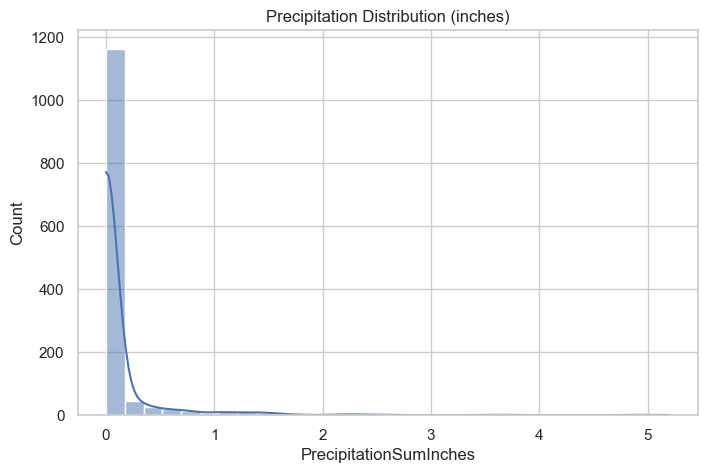

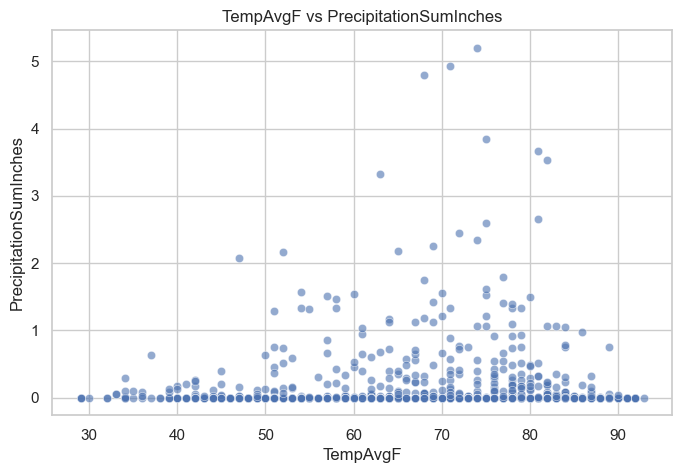

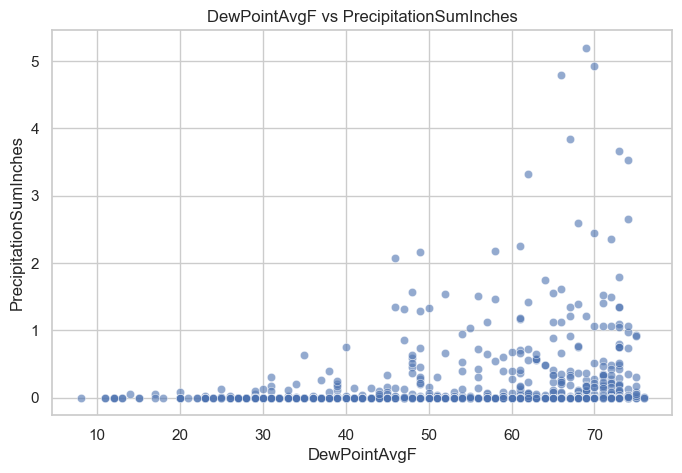

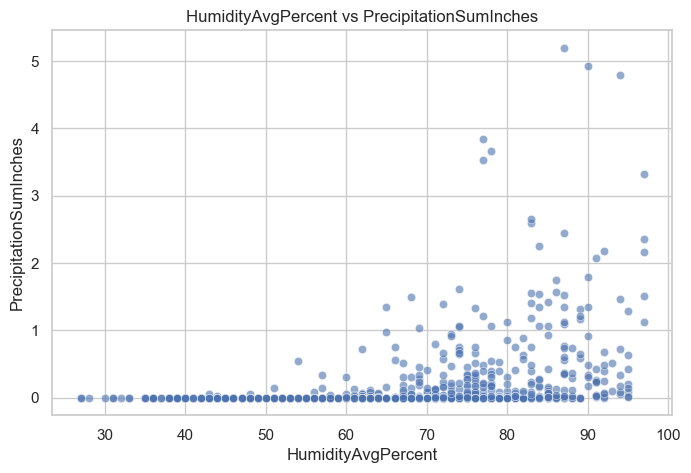

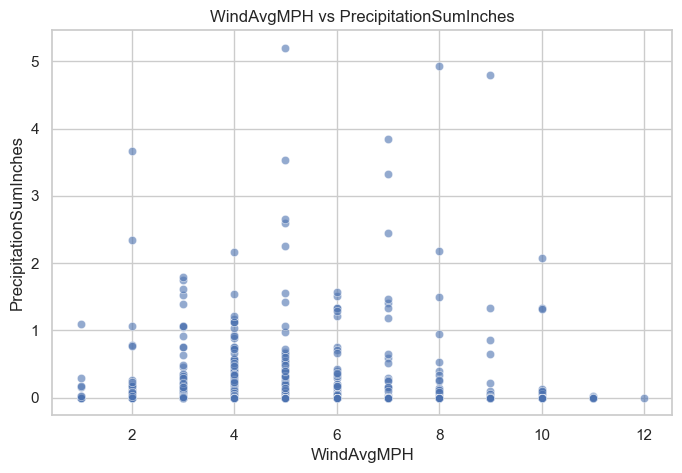

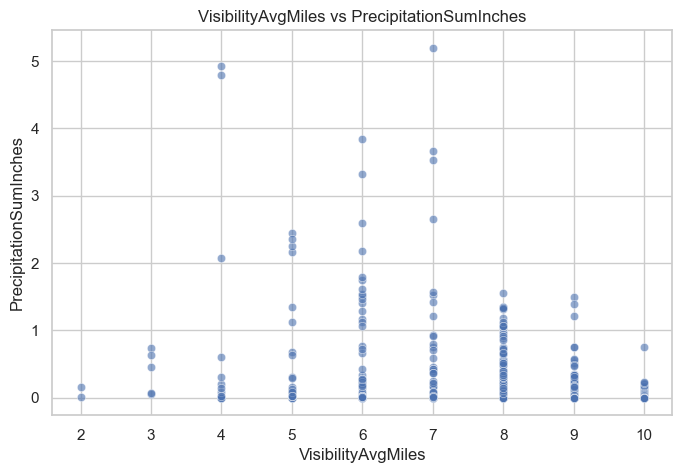

In [5]:
# Plot precipitation distribution
plt.figure()
sns.histplot(df_clean[prec_col], bins=30, kde=True)
plt.title('Precipitation Distribution (inches)')
plt.xlabel('PrecipitationSumInches')
plt.show()

# Scatter relationships
for feature in ['TempAvgF','DewPointAvgF','HumidityAvgPercent','WindAvgMPH','VisibilityAvgMiles']:
    if feature in df_clean.columns:
        plt.figure()
        sns.scatterplot(x=df_clean[feature], y=df_clean[prec_col], alpha=0.6)
        plt.xlabel(feature)
        plt.ylabel(prec_col)
        plt.title(f'{feature} vs {prec_col}')
        plt.show()

## 4. Modeling — Linear Regression

Use a few predictors to model precipitation.

In [6]:
# Select features (available ones)
features = [c for c in ['TempAvgF','DewPointAvgF','HumidityAvgPercent','WindAvgMPH','VisibilityAvgMiles'] if c in df_clean.columns]
target = prec_col
print('Features used:', features)

X = df_clean[features].values
y = df_clean[target].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict & evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('MSE:', round(mse,6))
print('MAE:', round(mae,6))
print('R2:', round(r2,4))

# Coefficients
coef_dict = dict(zip(features, model.coef_))
print('\nCoefficients:')
for k,v in coef_dict.items():
    print(f' - {k}: {v:.6f}')
print('Intercept:', model.intercept_)

Features used: ['TempAvgF', 'DewPointAvgF', 'HumidityAvgPercent', 'WindAvgMPH', 'VisibilityAvgMiles']
MSE: 0.093586
MAE: 0.148517
R2: 0.2114

Coefficients:
 - TempAvgF: 0.006753
 - DewPointAvgF: -0.005957
 - HumidityAvgPercent: 0.007781
 - WindAvgMPH: 0.011116
 - VisibilityAvgMiles: -0.108462
Intercept: 0.3987676534353737


## 5. Actual vs Predicted

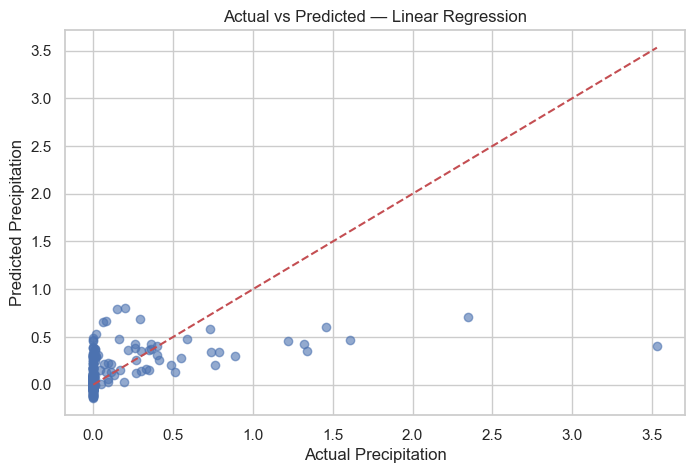

In [7]:
plt.figure()
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Precipitation')
plt.ylabel('Predicted Precipitation')
plt.title('Actual vs Predicted — Linear Regression')
plt.show()

## 6. Conclusions

Summarize findings and limitations. Consider more advanced models (e.g., RandomForest) and feature engineering for better performance.